In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dense, MaxPooling2D, Conv2D
from keras.layers import Input, Activation, Add
from keras.models import Model, load_model
from keras.regularizers import l2
from keras.optimizers import Adam, Adagrad, Adadelta, Adamax, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Dataset: https://www.kaggle.com/datasets/jangedoo/utkface-new

### Importing data

In [2]:
fldr = "./UTKFace"

In [3]:
files = os.listdir(fldr)

In [4]:
print(files[0], len(files))

100_0_0_20170112213500903.jpg.chip.jpg 23708


The labels of each face image is embedded in the file name, formated like [age]\_[gender]\_[race]\_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age 

[gender] is either 0 (male) or 1 (female)

[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

### Finding and changing color channel to RGB

In [5]:
image_path = fldr+"/"+files[0]
image = cv2.imread(image_path)

# Get the shape of the image
height, width, channels = image.shape

# Print the color space information
if channels == 1:
    print("Image is in Grayscale (single channel) mode.")
elif channels == 3:
    print("Image is in BGR (Blue, Green, Red) color space.")
elif channels == 4:
    print("Image is in BGRA (Blue, Green, Red, Alpha) color space.")
else:
    print(f"Image has {channels} channels. Color space may vary.")


Image is in BGR (Blue, Green, Red) color space.


In [6]:
ages=[]
images=[]

for f in files:
    age = int(f.split("_")[0])
    ages.append(age)
    total = fldr+"/"+f
    # print(total)
    image = cv2.imread(total)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64,64))
    images.append(image)


In [7]:
# print(ages)
# print(genders)
# print(images)

### Saving data to numpy arrays

In [8]:
ages = np.array(ages)
images = np.array(images)

In [9]:
np.save("UTKFaceChildAges.npy", ages)
np.save("UTKFaceChildImages.npy", images)

In [10]:
# Load the arrays from the files
ages = np.load('UTKFaceChildAges.npy')
images = np.load('UTKFaceChildImages.npy')

### Find no. of elements in dataset and plot

In [11]:
values, counts = np.unique(ages, return_counts=True)
print(f"{values}\n{counts}")

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 103 105 110 111 115 116]
[1123  482  289  273  196  131  139  263  166  156   65  130   81  157
  177  247  158  262   98  284  346  395  426  859  734 2197  615  918
  570  724  350  664  143  409  880  483  293  325  266  526  132  266
  157  100  440  153  170  153  148  381  138  232  241  353  268  236
   97  271   82  293  161  125  103   50  259   77   94  100   56  147
   33   98   63   32  148   58   28   69   23  133   22   40   18   24
  155   35   10   34   33   82    2   13    5    9   17    9   11    2
    1    5    5    1    3    4]


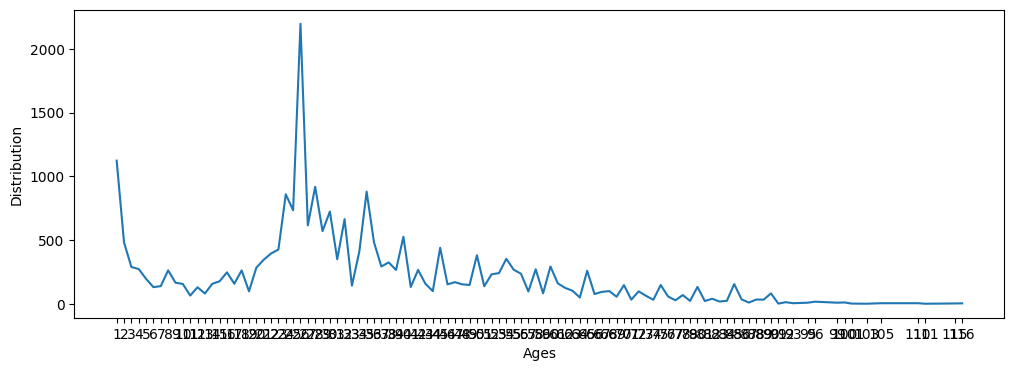

In [12]:
fig=plt.figure(figsize=(12,4))
plt.plot(values, counts)
plt.xticks(values)
plt.xlabel("Ages")
plt.ylabel("Distribution")
plt.show()

### Labels for output

In [13]:
labels=[]
i=0
while i<len(ages):
    label=[]
    label.append(ages[i])
    if(ages[i]<18):
        label.append(1)
    else:
        label.append(0)
    labels.append(label)
    i=i+1

In [14]:
images_2 = images/255
images_2.shape

(23708, 64, 64, 3)

In [15]:
labels = np.array(labels)

### Train Test Split

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(images_2,labels,test_size=0.25,random_state=42)

In [17]:
Y_train[0:5]

array([[25,  0],
       [30,  0],
       [70,  0],
       [71,  0],
       [26,  0]])

In [18]:
Y_train_2 = [Y_train[:,1],Y_train[:,0]]
Y_test_2 = [Y_test[:,1],Y_test[:,0]]

In [19]:
Y_train_2

[array([0, 0, 0, ..., 1, 0, 1]), array([25, 30, 70, ..., 16, 40,  9])]

### Defining the model

In [20]:
def convolution(input_tensor, filters):
    x=Conv2D(filters=filters, kernel_size=(3,3),padding="same",strides=(1,1),kernel_regularizer=l2(0.001))(input_tensor)
    x=Dropout(0.1)(x)
    x=Activation("relu")(x)
    return x  

In [21]:
def model(input_shape):
    inputs = Input((input_shape))
    conv_1=convolution(inputs, 32)
    maxp_1=MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2=convolution(maxp_1, 64)
    maxp_2=MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3=convolution(maxp_2, 128)
    maxp_3=MaxPooling2D(pool_size=(2,2))(conv_3)
    conv_4=convolution(maxp_3, 256)
    maxp_4=MaxPooling2D(pool_size=(2,2))(conv_4)
    conv_5=convolution(maxp_4, 512)
    maxp_5=MaxPooling2D(pool_size=(2,2))(conv_5)
    flatten=Flatten()(maxp_5)
    dense_1=Dense(64,activation="swish")(flatten)
    dense_2=Dense(64,activation="swish")(flatten)
    drop_1=Dropout(0.2)(dense_1)
    drop_2=Dropout(0.2)(dense_2)
    output_1=Dense(1,activation="sigmoid",name="child_out")(drop_1)
    output_2=Dense(1,activation="swish",name="age_out")(drop_2)
    model=Model(inputs=[inputs],outputs=[output_1,output_2])
    model.compile(loss=["binary_crossentropy","mae"],optimizer="Adam",metrics=["accuracy"])
    return model

In [22]:
Model = model((48,48,3))
Model

In [23]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 48, 48, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 48, 48, 32)           0         ['dropout[0][0]']             
                                                                                              

In [24]:
fle_s = "child_detection.h5"
checkpoint=ModelCheckpoint(fle_s,monitor="val_loss",verbose=1,save_best_only=True,save_weights_only=False,mode="auto",save_freq="epoch")
early_stop=EarlyStopping(patience=50,monitor="val_loss",restore_best_weights=True)
callback_list=[checkpoint,early_stop]

In [ ]:
# Use google colab GPU for faster epoch runs
History=Model.fit(X_train,Y_train_2,batch_size=64,validation_data=(X_test,Y_test_2),epochs=250,callbacks=callback_list)

In [ ]:
# Save history to a file
with open('training_history_child_detect.pkl', 'wb') as file:
    pickle.dump(History.history, file)

In [ ]:
Model = load_model("child_detection.h5")

In [ ]:
# load history
with open('training_history_child_detect.pkl', 'rb') as file:
    History = pickle.load(file)

In [ ]:
Model.evaluate(X_test, Y_test_2)

In [ ]:
pred=Model.predict(X_test)

In [ ]:
pred[0]

In [ ]:
# Access loss values directly from the dictionary
loss = History["loss"]
val_loss = History["val_loss"]
child_out_accuracy = History["child_out_accuracy"]
val_child_out_accuracy = History["val_child_out_accuracy"]

In [ ]:
# plt.plot(History.history["loss"])
# plt.plot(History.history["val_loss"])
# plt.title("Model Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend(["Train", "Validation"],loc="upper left")
# plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [ ]:
plt.plot(loss)
plt.plot(val_loss)
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"],loc="upper left")
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [ ]:
# plt.plot(History.history["sex_out_accuracy"])
# plt.plot(History.history["val_sex_out_accuracy"])
# plt.title("Model Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend(["Train", "Validation"],loc="upper left")
# plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [ ]:
plt.plot(child_out_accuracy)
plt.plot(val_child_out_accuracy)
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"],loc="upper left")
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(Y_test_2[1],pred[1])
ax.plot([Y_test_2[1].min(),Y_test_2[1].max()],[Y_test_2[1].min(),Y_test_2[1].max()],"k--",lw=4)
ax.set_title("Age Prediction Accuracy")
ax.set_xlabel("Actual Age")
ax.set_ylabel("Predicted Age")

### Report and Results

In [ ]:
i=0
Pred_l=[]
while(i<len(pred[0])):
    Pred_l.append(int(np.round(pred[0][i])))
    i=i+1

In [ ]:
report=classification_report(Y_test_2[0],Pred_l)
print(report)

In [ ]:
results=confusion_matrix(Y_test_2[0],Pred_l)
sns.heatmap(results,annot=True)

### Tests

In [ ]:
def test_image(ind, images, images_2, Model):
    plt.imshow(images[ind])
    image_test=images_2[ind]
    pred_l=Model.predict(np.array([image_test]))
    child_or_not=["Yes","No"]
    age=int(np.round(pred_l[1][0]))
    child=int(np.round(pred_l[0][0]))
    print("Predicted Age:", str(age))
    print("Predicted Gender:", child_or_not[child])

In [ ]:
test_image(4,images,images_2,Model)